### Step 0: To start ...

In [1]:
# Turn on multi-threading on your computer for faster calculation
%env OMP_NUM_THREADS = 4

env: OMP_NUM_THREADS=4


# Install and load the necessary packages and libraries

In [4]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, confusion_matrix, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import warnings
warnings.filterwarnings("ignore")

# Load the data

In [5]:
df = pd.read_csv('6722-credit-card-default-data.csv', index_col='ID')
df.head() 

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
ID,,,,,,,,,,,,,,,,,,,,,
1,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
5,50000.0,1,1,2,37,0,0,0,0,0,...,19394.0,19619.0,20024.0,2500.0,1815.0,657.0,1000.0,1000.0,800.0,0


In [6]:
df.info() # Checking what kinds of data we have


<class 'pandas.core.frame.DataFrame'>
Index: 24000 entries, 1 to 24000
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LIMIT_BAL  24000 non-null  float64
 1   SEX        24000 non-null  int64  
 2   EDUCATION  24000 non-null  int64  
 3   MARRIAGE   24000 non-null  int64  
 4   AGE        24000 non-null  int64  
 5   PAY_1      24000 non-null  int64  
 6   PAY_2      24000 non-null  int64  
 7   PAY_3      24000 non-null  int64  
 8   PAY_4      24000 non-null  int64  
 9   PAY_5      24000 non-null  int64  
 10  PAY_6      24000 non-null  int64  
 11  BILL_AMT1  24000 non-null  float64
 12  BILL_AMT2  24000 non-null  float64
 13  BILL_AMT3  24000 non-null  float64
 14  BILL_AMT4  24000 non-null  float64
 15  BILL_AMT5  24000 non-null  float64
 16  BILL_AMT6  24000 non-null  float64
 17  PAY_AMT1   24000 non-null  float64
 18  PAY_AMT2   24000 non-null  float64
 19  PAY_AMT3   24000 non-null  float64
 20  PAY_AMT4   

# Defining the vector of target (y) and matrix of features (X)

In [7]:
y = df['DEFAULT']
X = df.drop(columns = 'DEFAULT')

# Step 6:  Splitting X and y into training and testing

In [8]:
# For "apples-to-apples" comparisons, set a starting value ("seed") for the random number generator
np.random.seed(25300)

# split the data randomly into 80% train and 20% test samples
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, stratify=y)
# IMPORTANT: these samples are stratified, i.e., the proportion of retained and not-retained customers is the same in both

# Print the shapes of the resulting splits to verify sizes
print("Training feature set shape:", X_train.shape)
print("Test feature set shape:", X_test.shape)
print("Training label set shape:", y_train.shape)
print("Test label set shape:", y_test.shape)

Training feature set shape: (19200, 23)
Test feature set shape: (4800, 23)
Training label set shape: (19200,)
Test label set shape: (4800,)


# Train a model on the training data, Use it to predict the values in the testing data, Compute the metrics of the model and compare models

In [9]:
# First we define a set of functions to compute the metrics of the model

# ROC curve
def plot_roc(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1, drop_intermediate = False)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.001, 1.001])
    plt.ylim([-0.001, 1.001])
    plt.xlabel('1-Specificity (False Negative Rate)')
    plt.ylabel('Sensitivity (True Positive Rate)')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

# Confusion Matrix returns in the format: cm[0,0], cm[0,1], cm[1,0], cm[1,1]: tn, fp, fn, tp

# Sensitivity
def custom_sensitivity_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (tp/(tp+fn))

# Specificity
def custom_specificity_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (tn/(tn+fp))

# Positive Predictive Value
def custom_ppv_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (tp/(tp+fp))

# Negative Predictive Value
def custom_npv_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (tn/(tn+fn))

# Accuracy
def custom_accuracy_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return ((tn+tp)/(tn+tp+fn+fp))

# MVP: Logistic regression

In [10]:
# define the model and call it classifier_LR
classifier_LR = LogisticRegression(solver='liblinear')

# train classifier_LR on the training data
classifier_LR.fit(X_train, y_train)

# This is a regression, so it has coefficients -- lets see them
# Note, there is no easy way to show significance, etc. with sklearn
print('Intercept: ' + str(classifier_LR.intercept_))
#print('Coefficients (10 largest and 10 smallest) [recall, there are 252 of them, in total: ')
summary = pd.DataFrame([X_test.columns,classifier_LR.coef_[0]]).transpose().sort_values(by = 1, ascending = False)
summary.columns = ['Variable','Coefficient']

print (summary)
#top10positive = summary.head(10) # 10 largest (by value)
#print(top10positive)

#top10negative = summary.tail(10) # 10 smallest (by value)
#print(top10negative)



Intercept: [-0.00056983]
     Variable Coefficient
5       PAY_1    0.001987
6       PAY_2    0.001557
7       PAY_3    0.001399
8       PAY_4    0.001285
9       PAY_5    0.001199
10      PAY_6    0.001143
15  BILL_AMT5    0.000007
12  BILL_AMT2    0.000005
13  BILL_AMT3    0.000002
16  BILL_AMT6    0.000001
14  BILL_AMT4   -0.000002
22   PAY_AMT6   -0.000002
0   LIMIT_BAL   -0.000003
21   PAY_AMT5   -0.000005
19   PAY_AMT3   -0.000006
11  BILL_AMT1    -0.00001
20   PAY_AMT4   -0.000013
18   PAY_AMT2   -0.000019
17   PAY_AMT1   -0.000036
1         SEX   -0.001075
3    MARRIAGE   -0.001164
2   EDUCATION   -0.001213
4         AGE    -0.01442


In [11]:
average_of_ones = df['DEFAULT'].mean()

print("Average of 1s in the column:", average_of_ones)

Average of 1s in the column: 0.22108333333333333


In [11]:
# Use the trained model to predict testing data

y_pred_prob = classifier_LR.predict_proba(X_test)[:,1] # probabilities

# Select the threshold value -- we will use Т=0.23, about 0.01 more than the average of clients who did not default.
class_threshold = average_of_ones

y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # applying the threshold rule to classify

print(y_pred_prob[0:5]) # first 5 probabilities
print(y_pred[0:5]) # resultant predicted classification
print(y_test[0:5]) # actual outcomes

# oops ... for the first 5 customers our model made two mistakes: on 1st customer ("false positive") and on 3rd customer ("false negative")


[0.27383571 0.27987254 0.39509289 0.19370026 0.23523497]
[1 1 1 0 1]
ID
11189    1
22860    0
7618     1
3926     0
20935    0
Name: DEFAULT, dtype: int64


Metrics of the logistic regression model: 

Confusion matrix: 
[[1686  264]
 [2053  797]]
                                   Accuracy: 0.5172916666666667
                   SENSITIVITY (aka RECALL): 0.7511781338360037
                 SPECIFICITY (aka FALL-OUT): 0.4509227066060444
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.27964912280701754
                 NEGATIVE PREDICTIVE VALUE): 0.8646153846153846


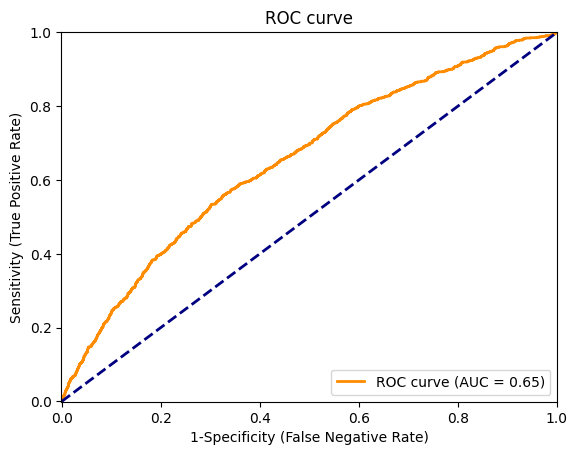

 AUC: 0.6523154693919632


In [12]:
# Lets look at the model metrics
print('Metrics of the logistic regression model: \n')

cm = np.transpose(confusion_matrix(y_test, y_pred))

print("Confusion matrix: \n" + str(cm))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred)))
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))


In [13]:
# Apply variable selection with Stepwise Recursive Feature Selection

from sklearn.feature_selection import RFE

rfe = RFE(estimator=classifier_LR, n_features_to_select=20, step=1) # in this example we will select 20 variables; this number "20" is a hyperparameter to tune
rfe.fit(X_train, y_train)
ranking = rfe.ranking_.reshape(len(X_train.columns))

# which 20 variables are in the model?
pd.DataFrame([X_test.columns,ranking]).transpose().sort_values(1).head(30)


,0,1
0,LIMIT_BAL,1
20,PAY_AMT4,1
19,PAY_AMT3,1
18,PAY_AMT2,1
17,PAY_AMT1,1
15,BILL_AMT5,1
12,BILL_AMT2,1
21,PAY_AMT5,1
10,PAY_6,1
11,BILL_AMT1,1


Metrics of the logistic regression model after variable selection: 

Confusion matrix: 
[[1730  284]
 [2009  777]]
                                   Accuracy: 0.5222916666666667
                   SENSITIVITY (aka RECALL): 0.7323279924599434
                 SPECIFICITY (aka FALL-OUT): 0.46269055897298744
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.27889447236180903
                 NEGATIVE PREDICTIVE VALUE): 0.858987090367428


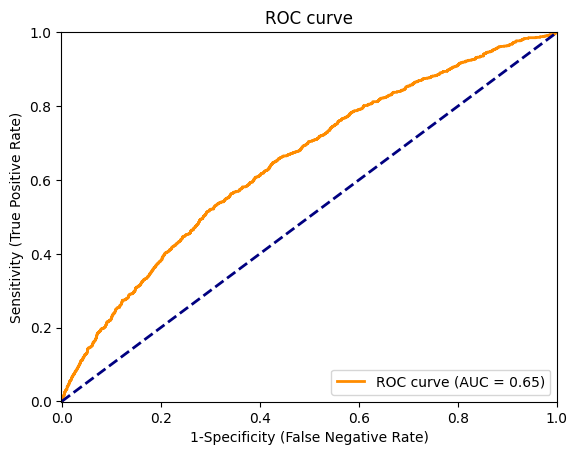

 AUC: 0.6484952782639317


In [14]:
# Train the model and call it classifier_LR_RFE


rfe = RFE(estimator=classifier_LR, n_features_to_select= 20, step=1)
classifier_LR_RFE = rfe.fit(X_train, y_train)

# Use the trained model to predict testing data
y_pred_prob = classifier_LR_RFE.predict_proba(X_test)[:,1] # probabilities
y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # classification


# Lets look at the model metrics after variable selection
print('Metrics of the logistic regression model after variable selection: \n')

cm = np.transpose(confusion_matrix(y_test, y_pred))
print("Confusion matrix: \n" + str(cm))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred)))
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))


### Summary for Logistic Regression:

- We first trained the model with the entire set of 24 variables
- When applied to testing data, AUC=65.23%
- Through variable selection AUC decreased to 64.85%

# Method №2: Classification and Regression Tree, CART (aka "decision tree")


In [15]:
# Define a CART model and call it classifier_DT
classifier_DT = DecisionTreeClassifier(max_leaf_nodes = 5, random_state=25300) # random_state -- is same as random seed, neede to get the same result every time we rerun

# Train the model classifier_DT on the training data
classifier_DT.fit(X_train, y_train)

#  Use the trained model to predict testing data
y_pred_prob = classifier_DT.predict_proba(X_test)[:,1] # probabilities
y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # classification

print(y_pred_prob[0:10]) # first 5 probabilities
print(y_pred[0:10]) # resultant predicted classification
print(y_test[0:10]) # actual outcomes

# WOW -- the CART model made no mistakes on the first 5 customers!


[0.10811304 0.22222222 0.42097902 0.10811304 0.22222222 0.69495885
 0.10811304 0.69495885 0.22222222 0.69495885]
[0 1 1 0 1 1 0 1 1 1]
ID
11189    1
22860    0
7618     1
3926     0
20935    0
14945    1
21582    0
9578     1
13954    1
23555    1
Name: DEFAULT, dtype: int64


CART tree with 5 leafs


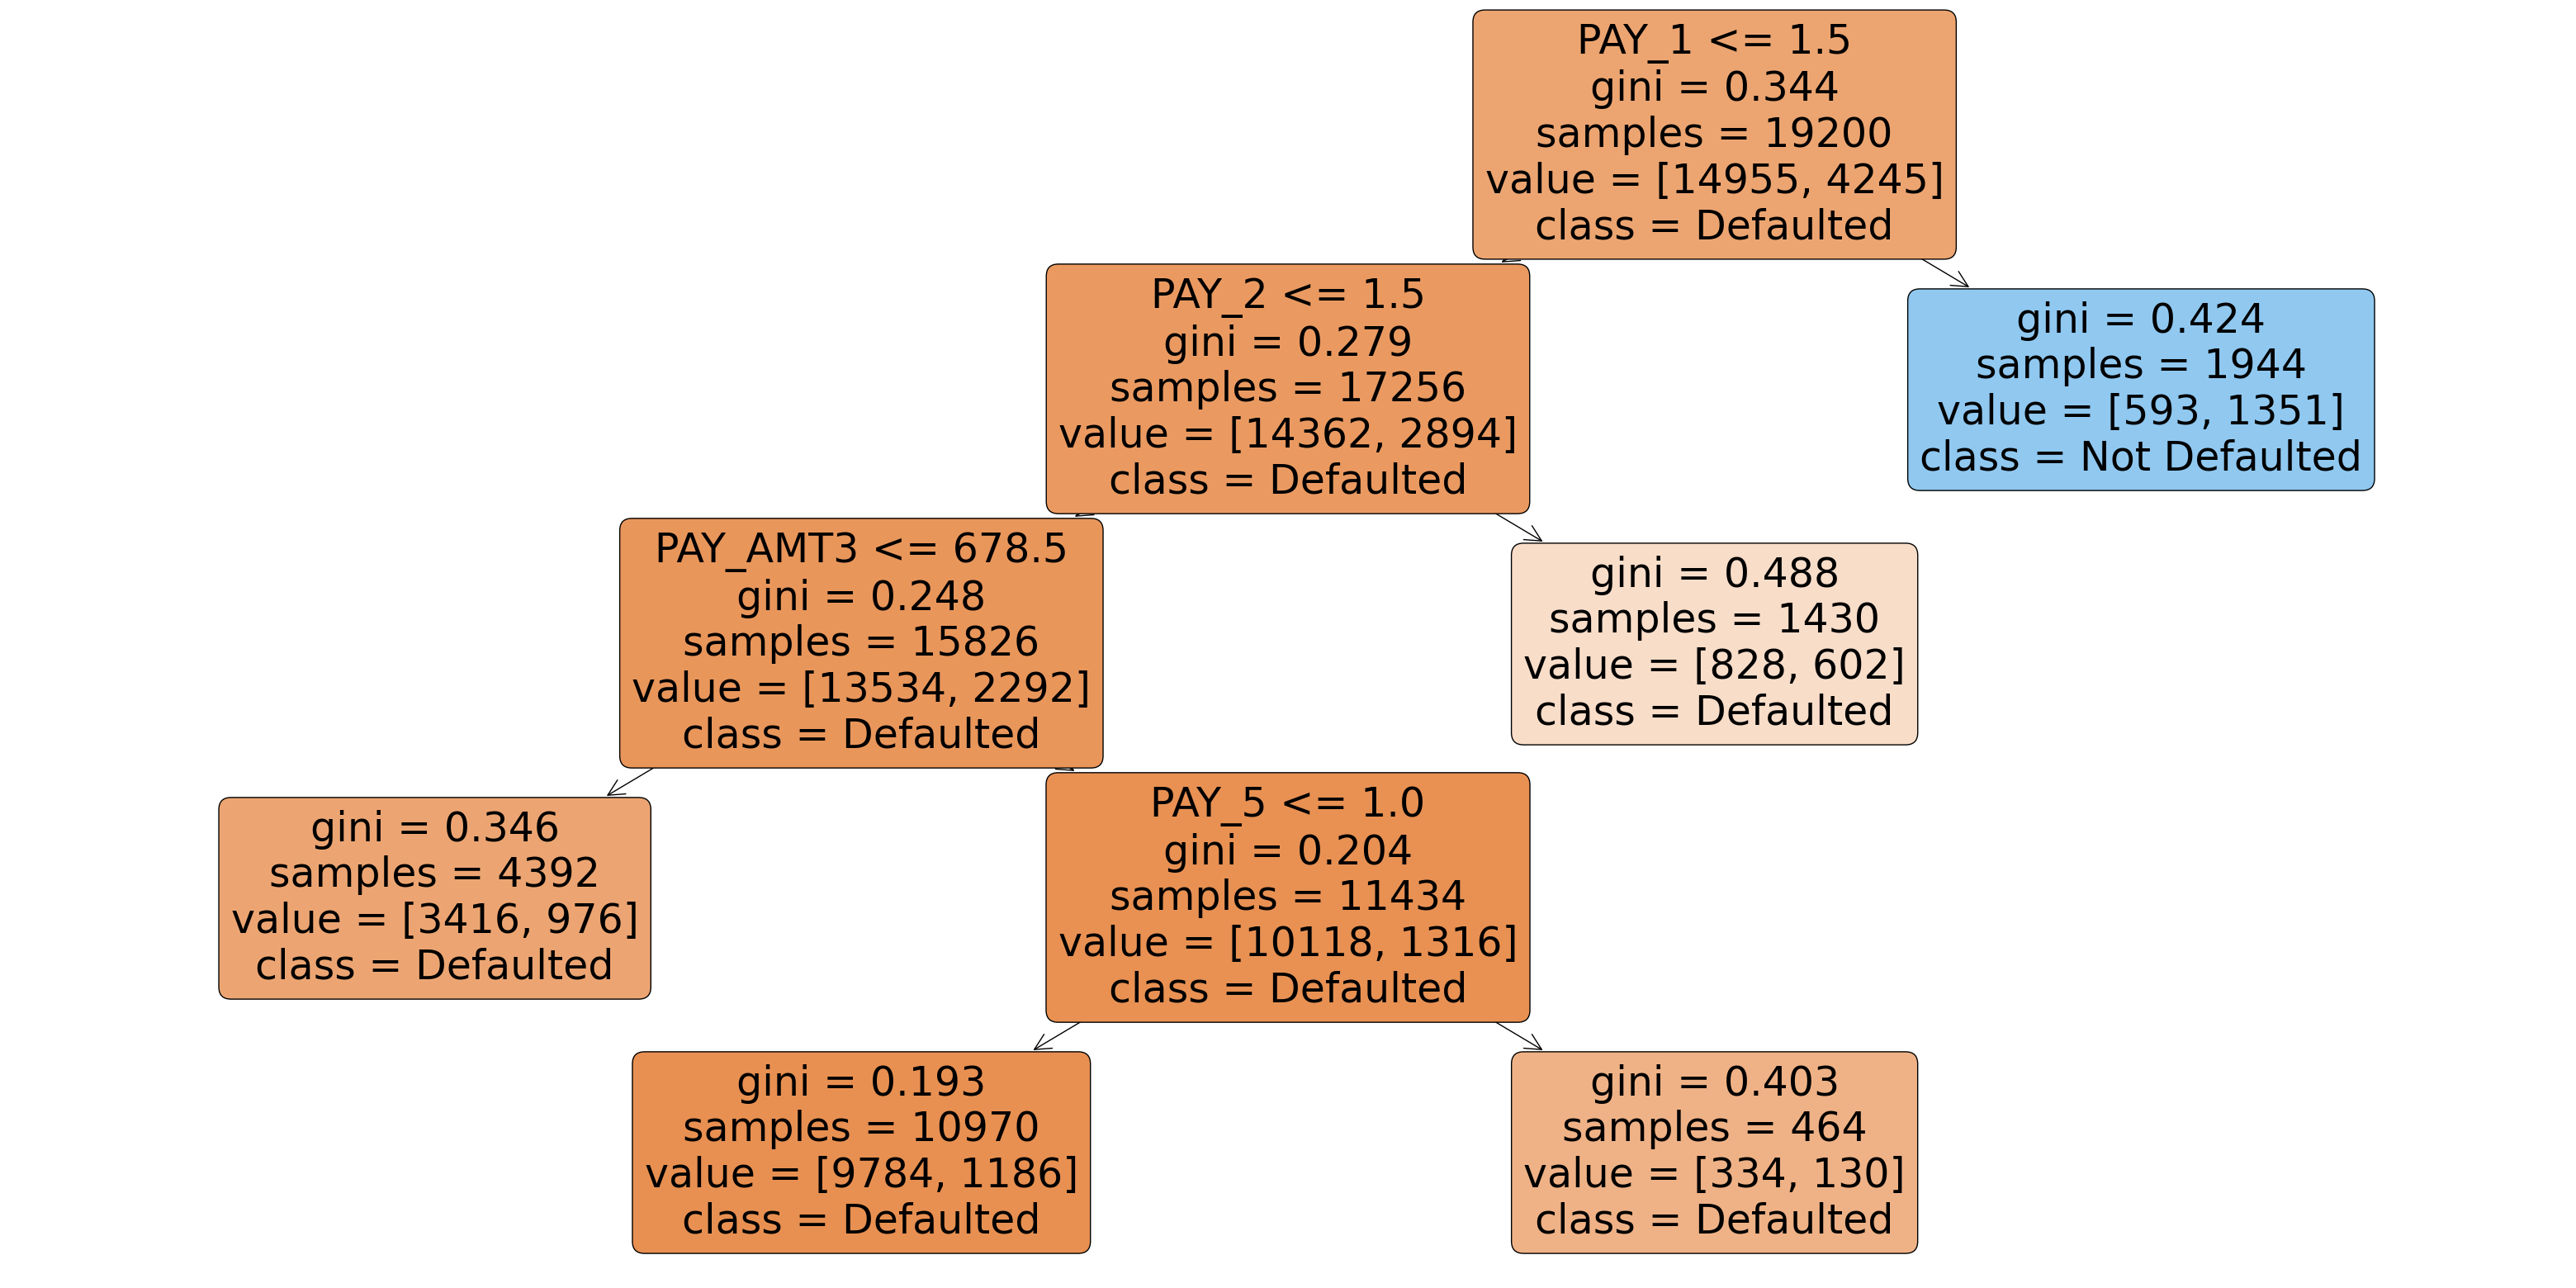

In [16]:
###### Visualizing the resultant tree

from sklearn import tree

plt.figure(figsize=(40,20))
tree.plot_tree(classifier_DT.fit(X_train, y_train), feature_names = X_train.columns, filled = True,
               class_names = ['Defaulted', 'Not Defaulted'], rounded = True)
print('CART tree with 5 leafs')


Metrics of the CART model: 

Confusion matrix: 
[[2408  273]
 [1331  788]]
                                   Accuracy: 0.6658333333333334
                   SENSITIVITY (aka RECALL): 0.7426955702167767
                 SPECIFICITY (aka FALL-OUT): 0.6440224658999733
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.37187352524775835
                 NEGATIVE PREDICTIVE VALUE): 0.8981723237597912


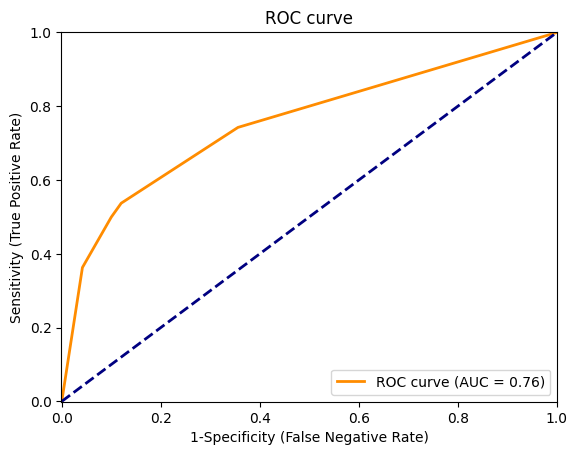

 AUC: 0.7552380479440919


In [17]:
# Lets look at the model metrics

print('Metrics of the CART model: \n')

cm = np.transpose(confusion_matrix(y_test, y_pred))
print("Confusion matrix: \n" + str(cm))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred)))
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))

In [18]:
# Hyper-parameter tuning. A CART model has multiple hyper-parameters, for instance:
# -- max number of leaves on a tree,
# -- min number of datapoints at a leaf
# -- min number of datapoints to create a split
# and so on

DecisionTreeClassifier() # display what those hyper-parameters are and their default values

DecisionTreeClassifier()

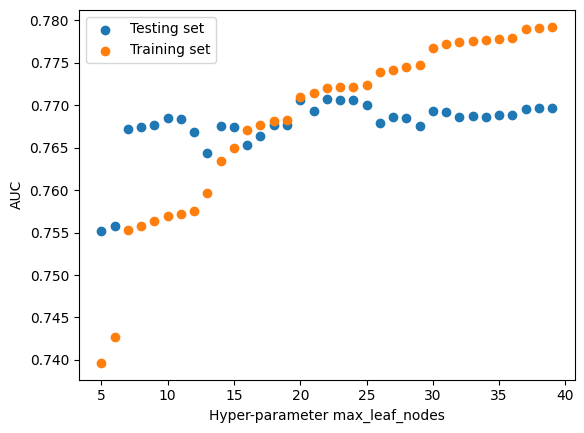

In [19]:
# Tuning hyper-parameter max_leaf_nodes

n_max_leaf_nodes = range(5,40) # Lets train the models with 5, 6, 7, ... 40 leafs

# for each model calculate AUC for testing
array = []
for n in n_max_leaf_nodes:

    classifier_DT = tree.DecisionTreeClassifier(criterion = 'gini', max_leaf_nodes = n)
    classifier_DT = classifier_DT.fit(X_train, y_train)

    y_pred_prob = classifier_DT.predict_proba(X_test)[:,1]
    y_pred = np.where(y_pred_prob > class_threshold, 1, 0)

    array.append([n,roc_auc_score(y_test, y_pred_prob)])

# plot the testing set AUCs
array = pd.DataFrame(array)
plt.scatter(array[0],array[1])

# now for each model calculate AUC on training
array = []
for n in n_max_leaf_nodes:

    classifier_DT = tree.DecisionTreeClassifier(criterion = 'gini', max_leaf_nodes = n)
    classifier_DT = classifier_DT.fit(X_train, y_train)

    y_pred_prob = classifier_DT.predict_proba(X_train)[:,1]
    y_pred = np.where(y_pred_prob > class_threshold, 1, 0)

    array.append([n,roc_auc_score(y_train, y_pred_prob)])

# plot the training set AUCs
array = pd.DataFrame(array)
plt.scatter(array[0],array[1])

# label the axes on the plot
plt.xlabel('Hyper-parameter max_leaf_nodes')
plt.ylabel('AUC')

# add the legend
plt.legend(['Testing set','Training set'])


## This plot illustrates the concept of "overfitting":  

- the more leafs the tree has, the higher is the AUC on the training data

- at leaf ~21 we have a good intersection of the AUC and number of leaves, making 21 the most ideal number of leaves.

In [20]:
# lets train the model with 21 leafs
classifier_DT = tree.DecisionTreeClassifier(criterion = 'gini', max_leaf_nodes = 20)
classifier_DT = classifier_DT.fit(X_train, y_train)

# obtain its predictions
y_pred_prob = classifier_DT.predict_proba(X_test)[:,1]
y_pred = np.where(y_pred_prob > class_threshold, 1, 0)

# calclate and print the AUC
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))

 AUC: 0.7706530422005713


## Summary for CART:

- we first trained the model with default hyper-parameters
- applying it to testing set we got AUC=75.5%
- we then tuned the hyper-paramter max_leaf_nodes and increased AUC to 77.1%

# Method №3: Random Forest

In [21]:
# Define a random forest model and call it classifier_RF
classifier_RF = RandomForestClassifier(random_state=25300) # recall what random_state mean

# Train the model classifier_RF on the training data
classifier_RF.fit(X_train, y_train)

# A random forest model has many hyper-parameters, for example::
# -- the number of trees in the forest ensemble,
# -- voting rules,
# -- max number of leafs on each tree,
# -- min number of datapoints at a leaf
# and so on

RandomForestClassifier(random_state=25300)

Metrics of the Random Forest model: 

Confusion matrix: 
[[2660  331]
 [1079  730]]
                                   Accuracy: 0.70625
                   SENSITIVITY (aka RECALL): 0.6880301602262017
                 SPECIFICITY (aka FALL-OUT): 0.7114201658197379
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.4035378662244334
                 NEGATIVE PREDICTIVE VALUE): 0.8893346706787028


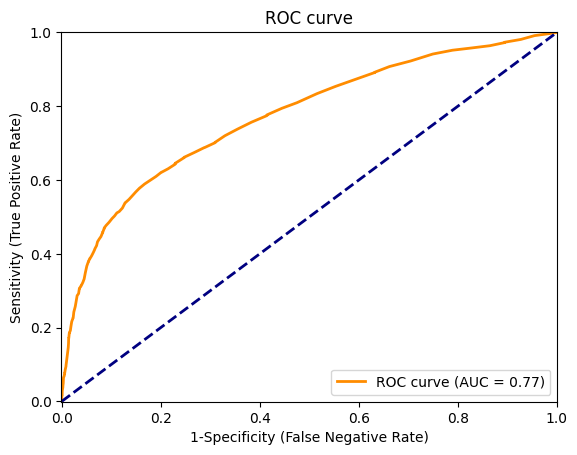

 AUC: 0.7724387389310876


In [22]:
# Use the trained model to predict testing data
y_pred_prob = classifier_RF.predict_proba(X_test)[:,1] # probabilities
y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # classification

# Lets look at the model metrics

print('Metrics of the Random Forest model: \n')

cm = np.transpose(confusion_matrix(y_test, y_pred))
print("Confusion matrix: \n" + str(cm))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred)))
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))


Optimized hyper-parameters:{'n_estimators': 600}
Metrics of the Random Forest model with the optimized hyper-parameter for the "number of trees": 

Confusion matrix: 
[[2681  312]
 [1058  749]]
                                   Accuracy: 0.7145833333333333
                   SENSITIVITY (aka RECALL): 0.705937794533459
                 SPECIFICITY (aka FALL-OUT): 0.7170366408130516
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.41449916989485336
                 NEGATIVE PREDICTIVE VALUE): 0.8957567657868359


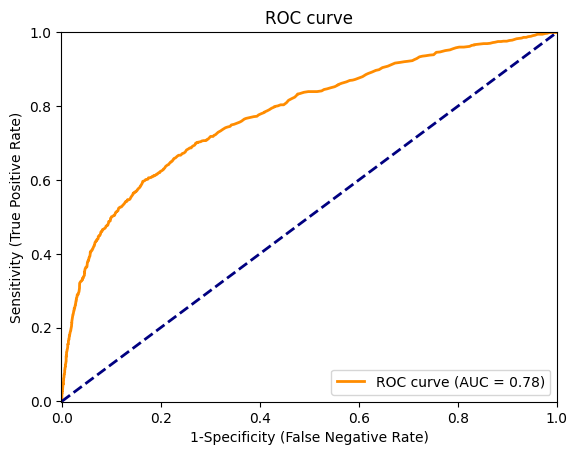

 AUC: 0.7798925859555607


In [25]:
# Hyper-parameter tuning ("optimization") using the function GridSearchCV for maximizing AUC
score_func = make_scorer(roc_auc_score, greater_is_better=True)


n_trees = [100, 200, 300, 400, 500, 600] # as an example, we will tune the "numeber of trees" hyper-parameter (n_trees) and we will consider values of 100, 200, ... 600 trees in the forest
Grid_srch_parameters_list = [ [{'n_estimators':n_trees}] ]


# we will apply a 5-fold cross-validation and call the resultant function "grid_search"
grid_search = GridSearchCV(estimator = classifier_RF,
                           cv = 5,
                           param_grid = Grid_srch_parameters_list[0],
                           scoring = score_func,
                           return_train_score = True)

# apply function grid_search to the training data, call the resultand best model grid_search_RF
grid_search_RF = grid_search.fit(X_train, y_train)

# use the best model to predict the testing data
y_pred_prob = grid_search_RF.predict_proba(X_test)[:,1] # probabilities
y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # classification

print('Optimized hyper-parameters:' + str(grid_search.best_params_))

# Lets look at the model metrics

print('Metrics of the Random Forest model with the optimized hyper-parameter for the "number of trees": \n')

cm = np.transpose(confusion_matrix(y_test, y_pred))
print("Confusion matrix: \n" + str(cm))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred)))
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))


<Axes: title={'center': 'Feature Importance'}>

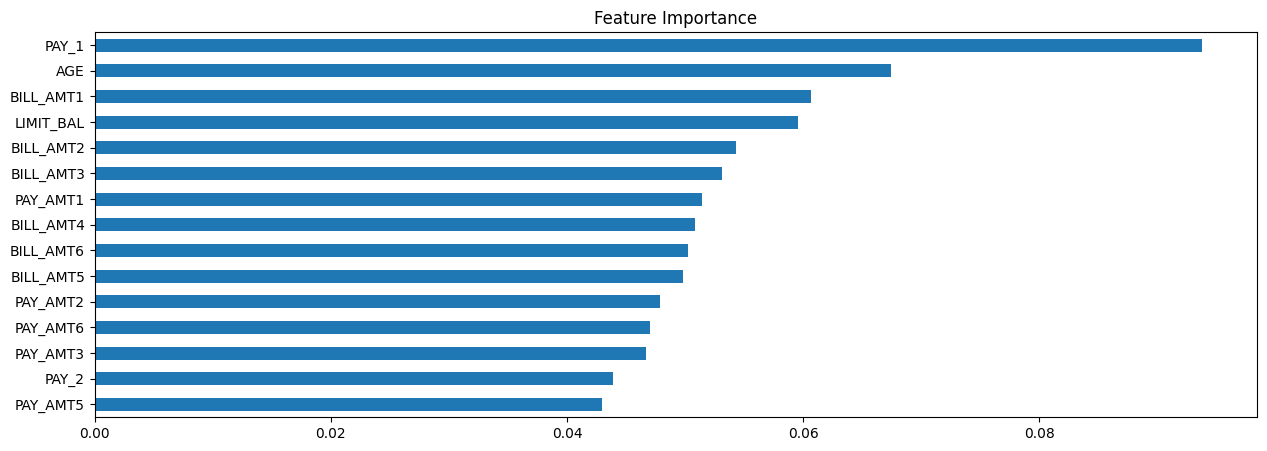

In [26]:
# calculate feature importances
importances = grid_search_RF.best_estimator_.feature_importances_

# plot them
plt.figure(figsize=(15,5))
plt.title('Feature Importance')
plt.xlabel('Decrease in Gini (recal, Gini = 2*AUC-1)')
feature_importances = pd.Series(classifier_RF.feature_importances_, index=X_train.columns)
feature_importances.nlargest(15).sort_values().plot(kind='barh', align='center')

## Summary for Random Forest:

- we first trained the model with default hyper-parameters
- applying it to testing set we got AUC=77%
- we then tuned the hyper-paramter "number of trees" and increased AUC to 78%

# Method №4: Gradient Boosting Machine

In [114]:
# Define the gradient boosting machine model and call it classifier_GBM
classifier_GBM = GradientBoostingClassifier(random_state=25300)

# Train the model classifier_GBM on the training data
classifier_GBM.fit(X_train, y_train)

# A gradient boosting model has many hyper-parameters, for example::
# -- the number of trees in the forest ensemble,
# -- speed of boosting ("learning rate", "decay rate"),
# -- max number of leafs on each tree,
# -- min number of datapoints at a leaf
# and so on


GradientBoostingClassifier(random_state=25300)

Metrics of the Gradient Boosting Machine model: 

Confusion matrix: 
[[2941  353]
 [ 798  708]]
                                   Accuracy: 0.7602083333333334
                   SENSITIVITY (aka RECALL): 0.6672950047125353
                 SPECIFICITY (aka FALL-OUT): 0.7865739502540786
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.4701195219123506
                 NEGATIVE PREDICTIVE VALUE): 0.892835458409229


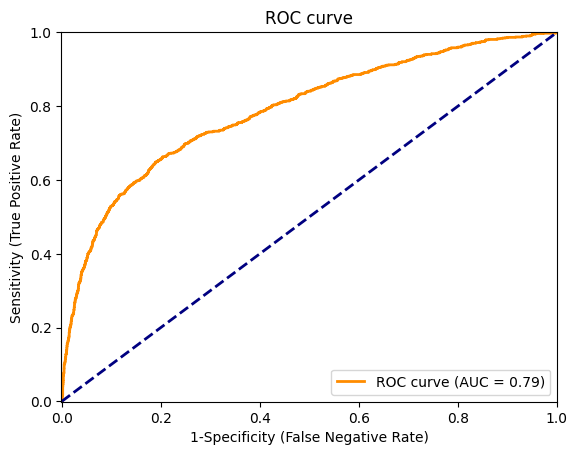

 AUC: 0.789022477243332


In [28]:
# Use the trained model to predict testing data
y_pred_prob = classifier_GBM.predict_proba(X_test)[:,1] # probabilities
y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # classification

# Lets look at the model metrics

print('Metrics of the Gradient Boosting Machine model: \n')

cm = np.transpose(confusion_matrix(y_test, y_pred))
print("Confusion matrix: \n" + str(cm))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred)))
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))

Optimized hyper-parameters:{'learning_rate': 0.1, 'n_estimators': 500}
Metrics of the Gradient Boosting Machine model with the optimized hyper-parameters": 

Confusion matrix: 
[[2871  354]
 [ 868  707]]
                                   Accuracy: 0.7454166666666666
                   SENSITIVITY (aka RECALL): 0.6663524976437323
                 SPECIFICITY (aka FALL-OUT): 0.7678523669430329
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.4488888888888889
                 NEGATIVE PREDICTIVE VALUE): 0.8902325581395348


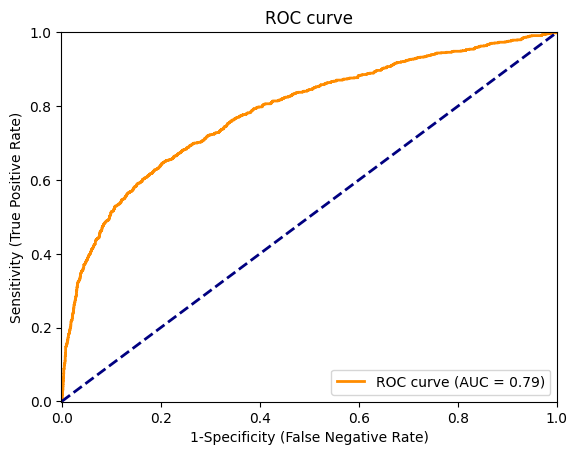

 AUC: 0.7853244162770643


In [29]:
# Hyper-parameter tuning ("optimization") using the function GridSearchCV for maximizing AUC
score_func = make_scorer(roc_auc_score, greater_is_better=True)

# as an example, we will tune two parameters
n_trees = [100, 200, 300, 400, 500, 600] # first, the "numeber of trees" hyper-parameter (n_trees) and we will consider values of 100, 200, ... 600 trees in the forest
learning_rates = [0.01, 0.1] # second, speed of boosting ("learning rate") and we will consider two values 0.01 и 0.1

Grid_srch_parameters_list = [ [{'n_estimators':n_trees, 'learning_rate': learning_rates}] ]

# we will apply a 5-fold cross-validation and call the resultant function "grid_search"
grid_search = GridSearchCV(estimator = classifier_GBM, cv = 5, param_grid = Grid_srch_parameters_list[0], scoring = score_func,
                              return_train_score = True)

# # apply function grid_search to the training data, call the resultant best model grid_search_GBM
grid_search_GBM = grid_search.fit(X_train, y_train)

# use the best model to predict the testing data
y_pred_prob = grid_search_GBM.predict_proba(X_test)[:,1] # probabilities
y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # classification

print('Optimized hyper-parameters:' + str(grid_search.best_params_))

# Lets look at the model metrics

print('Metrics of the Gradient Boosting Machine model with the optimized hyper-parameters": \n')

cm = np.transpose(confusion_matrix(y_test, y_pred))
print("Confusion matrix: \n" + str(cm))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred)))
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))


## Summary for Gradient Boosting:

- we first trained the model with default hyper-parameters
- applying it to testing set we got AUC=78.90%
- we then tuned two hyper-paramters "number of trees" and "learning rate" the model performed relatively worse with a decreased AUC at 78.5%

# Method №5: Support Vector Machines

In [30]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

svm_estimators = []
svm_estimators.append(('standardize', StandardScaler())) # scale the data
svm_estimators.append(('svm', svm.SVC(probability=True))) # define SVM with probabilities (recall, SVM be default does not predict probabilities)

# Define the support vectors machine model and call it classifier_SVM
Classifier_SVM = Pipeline(svm_estimators, verbose=False)

# Train the model classifier_SVM on the training data
Classifier_SVM.fit(X_train, y_train)

Pipeline(steps=[('standardize', StandardScaler()),
                ('svm', SVC(probability=True))])

Metrics of the Support Vector Machines model: 

Confusion matrix: 
[[3432  575]
 [ 307  486]]
                                   Accuracy: 0.81625
                   SENSITIVITY (aka RECALL): 0.4580584354382658
                 SPECIFICITY (aka FALL-OUT): 0.9178924846215566
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.6128625472887768
                 NEGATIVE PREDICTIVE VALUE): 0.8565011230346893


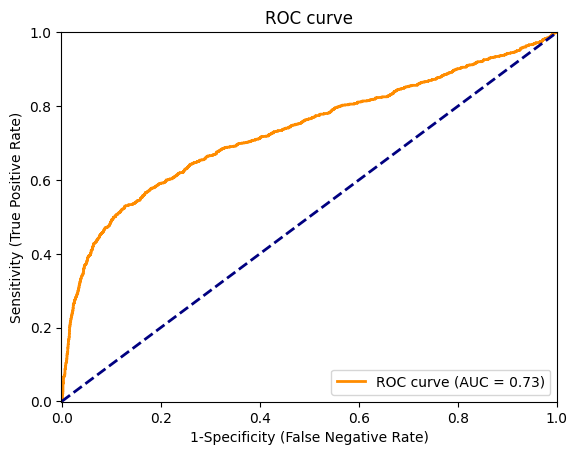

 AUC: 0.732734462812563


In [31]:
# use the fitted model to predict the testing data
y_pred_prob = Classifier_SVM.predict_proba(X_test)[:,1] # probabilities
y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # classification

# Lets look at the model metrics

print('Metrics of the Support Vector Machines model: \n')

cm = np.transpose(confusion_matrix(y_test, y_pred))
print("Confusion matrix: \n" + str(cm))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred)))
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))

#### Summary for SVM:

- we trained the model with default hyper-parameters
- applying it to testing set we got AUC=73.27%, only better than the logistic regression model


# Method №6: Artificial Neural Networks ("Deep Learning") with Tensor Flow

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.pipeline import Pipeline
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier, KerasRegressor 

In [2]:
# Define the architecture and optimization metrics for the network
def create_model():
    model = Sequential()
    model.add(Dense(12, input_dim=23, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Ensure the output layer is defined
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [62]:
nn_estimators = []
nn_estimators.append(('standardize', StandardScaler())) #scale the data
nn_estimators.append(('mlp', KerasClassifier(model=create_model, epochs=30, batch_size=64, validation_split=0.2))) # compile the model

# Define the TensorFlow Neural Network model and call it classifier_TF_NN
Classifier_TF_NN = Pipeline(nn_estimators, verbose=True)

# Train the model classifier_SVM on the training data
Classifier_TF_NN.fit(X_train, y_train)

<IPython.core.display.Javascript object>

[Pipeline] ....... (step 1 of 2) Processing standardize, total=   0.0s
Epoch 1/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step - accuracy: 0.6741 - loss: 0.6372 - val_accuracy: 0.7961 - val_loss: 0.5116
Epoch 2/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step - accuracy: 0.8038 - loss: 0.4923 - val_accuracy: 0.8065 - val_loss: 0.4777
Epoch 3/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step - accuracy: 0.8151 - loss: 0.4589 - val_accuracy: 0.8078 - val_loss: 0.4649
Epoch 4/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step - accuracy: 0.8192 - loss: 0.4492 - val_accuracy: 0.8102 - val_loss: 0.4603
Epoch 5/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step - accuracy: 0.8179 - loss: 0.4480 - val_accuracy: 0.8133 - val_loss: 0.4581
Epoch 6/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step - accuracy: 0.8178 - loss: 0.4463 - val_accuracy: 0.8135 - val_loss: 0.4555
Epoch 7/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step - accuracy: 0.8183 - loss: 0.4442 - val_accuracy: 0.8141 - val_loss: 0.4536
Epoch 8/30
240/240 

Pipeline(steps=[('standardize', StandardScaler()),
                ('mlp',
                 KerasClassifier(batch_size=64, epochs=30, model=<function create_model at 0x107ee03a0>, validation_split=0.2))],
         verbose=True)

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
Metrics of the Tensor Flow Neural Network model: 

Confusion matrix: 
[[2972  388]
 [ 767  673]]
                                   Accuracy: 0.759375
                   SENSITIVITY (aka RECALL): 0.6343072573044298
                 SPECIFICITY (aka FALL-OUT): 0.7948649371489703
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.4673611111111111
                 NEGATIVE PREDICTIVE VALUE): 0.8845238095238095


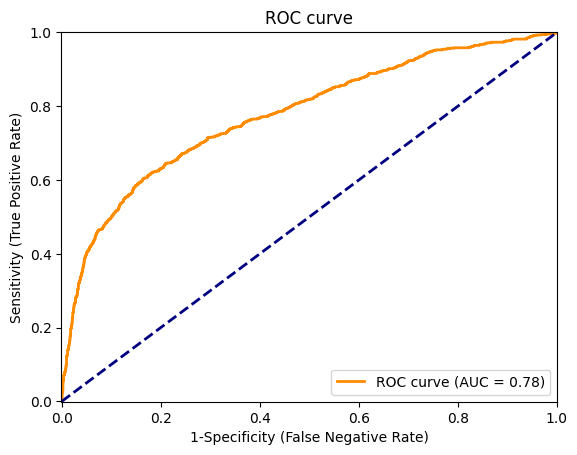

 AUC: 0.777542368074848


In [63]:
# use the fitted model to predict the testing data
class_threshold = 0.22
y_pred_prob = Classifier_TF_NN.predict_proba(X_test)[:,1] # probabilities
y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # classification

# Lets look at the model metrics

print('Metrics of the Tensor Flow Neural Network model: \n')

cm = np.transpose(confusion_matrix(y_test, y_pred))
print("Confusion matrix: \n" + str(cm))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred)))
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))

## Summary for Tensor Flow NN:

- we trained the model with default hyper-parameters and some "semi-randomly"-selected architecture
- applying it to testing set we got AUC=77.46% -- certainly not the best model we've seen so far.
- but the low AUC thus far should not discounrage you: ANNs have an enormous number of tunable hyper-parameters, starting at the high-level with the network architecture. Lots to experiment with, and learn -- good luck!

# Step 10: Finishing the anlayses -- export the model predictions for subsequent use

In [105]:
X_pred = pd.read_csv('6722-pilot-customers.csv')

In [106]:
X_pred['ID'] = X_pred['ID'].apply(lambda x:x[6:])
X_pred = X_pred.set_index('ID')

In [107]:
X_pred.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
ID,,,,,,,,,,,,,,,,,,,,,
1,500000.0,1,1,2,29,0,0,0,0,0,...,445007,542653,483003,473944,55000.0,40000.0,38000.0,20239,13750.0,13770
2,210000.0,1,1,2,29,-2,-2,-2,-2,-2,...,0,0,0,0,0.0,0.0,0.0,0,0.0,0
3,150000.0,1,1,2,27,0,0,0,0,0,...,89006,89775,87725,40788,4031.0,10006.0,3266.0,4040,1698.0,800
4,20000.0,1,2,1,38,0,0,0,0,0,...,19559,18240,17928,150,1699.0,1460.0,626.0,1750,150.0,0
5,400000.0,1,2,1,34,-1,-1,-1,-1,-1,...,11867,7839,14837,7959,9677.0,11867.0,7839.0,14837,7959.0,5712


In [108]:
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
ID,,,,,,,,,,,,,,,,,,,,,
1,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
5,50000.0,1,1,2,37,0,0,0,0,0,...,19394.0,19619.0,20024.0,2500.0,1815.0,657.0,1000.0,1000.0,800.0,0


In [109]:
X_pred.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 1 to 1000
Data columns (total 23 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LIMIT_BAL  1000 non-null   float64
 1   SEX        1000 non-null   int64  
 2   EDUCATION  1000 non-null   int64  
 3   MARRIAGE   1000 non-null   int64  
 4   AGE        1000 non-null   int64  
 5   PAY_1      1000 non-null   int64  
 6   PAY_2      1000 non-null   int64  
 7   PAY_3      1000 non-null   int64  
 8   PAY_4      1000 non-null   int64  
 9   PAY_5      1000 non-null   int64  
 10  PAY_6      1000 non-null   int64  
 11  BILL_AMT1  1000 non-null   int64  
 12  BILL_AMT2  1000 non-null   int64  
 13  BILL_AMT3  1000 non-null   int64  
 14  BILL_AMT4  1000 non-null   int64  
 15  BILL_AMT5  1000 non-null   int64  
 16  BILL_AMT6  1000 non-null   int64  
 17  PAY_AMT1   1000 non-null   float64
 18  PAY_AMT2   1000 non-null   float64
 19  PAY_AMT3   1000 non-null   float64
 20  PAY_AMT4   10

In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24000 entries, 1 to 24000
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LIMIT_BAL  24000 non-null  float64
 1   SEX        24000 non-null  int64  
 2   EDUCATION  24000 non-null  int64  
 3   MARRIAGE   24000 non-null  int64  
 4   AGE        24000 non-null  int64  
 5   PAY_1      24000 non-null  int64  
 6   PAY_2      24000 non-null  int64  
 7   PAY_3      24000 non-null  int64  
 8   PAY_4      24000 non-null  int64  
 9   PAY_5      24000 non-null  int64  
 10  PAY_6      24000 non-null  int64  
 11  BILL_AMT1  24000 non-null  float64
 12  BILL_AMT2  24000 non-null  float64
 13  BILL_AMT3  24000 non-null  float64
 14  BILL_AMT4  24000 non-null  float64
 15  BILL_AMT5  24000 non-null  float64
 16  BILL_AMT6  24000 non-null  float64
 17  PAY_AMT1   24000 non-null  float64
 18  PAY_AMT2   24000 non-null  float64
 19  PAY_AMT3   24000 non-null  float64
 20  PAY_AMT4   

In [112]:

X_pred['BILL_AMT1'] = X_pred['BILL_AMT1'].astype('float64')
X_pred['BILL_AMT2'] = X_pred['BILL_AMT2'].astype('float64')
X_pred['BILL_AMT3'] = X_pred['BILL_AMT3'].astype('float64')
X_pred['BILL_AMT4'] = X_pred['BILL_AMT4'].astype('float64')
X_pred['BILL_AMT5'] = X_pred['BILL_AMT5'].astype('float64')
X_pred['BILL_AMT6'] = X_pred['BILL_AMT6'].astype('float64')
X_pred['PAY_AMT4'] = X_pred['PAY_AMT4'].astype('float64')
X_pred['PAY_AMT6'] = X_pred['PAY_AMT6'].astype('float64')
X_pred.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 1 to 1000
Data columns (total 23 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LIMIT_BAL  1000 non-null   float64
 1   SEX        1000 non-null   int64  
 2   EDUCATION  1000 non-null   int64  
 3   MARRIAGE   1000 non-null   int64  
 4   AGE        1000 non-null   int64  
 5   PAY_1      1000 non-null   int64  
 6   PAY_2      1000 non-null   int64  
 7   PAY_3      1000 non-null   int64  
 8   PAY_4      1000 non-null   int64  
 9   PAY_5      1000 non-null   int64  
 10  PAY_6      1000 non-null   int64  
 11  BILL_AMT1  1000 non-null   float64
 12  BILL_AMT2  1000 non-null   float64
 13  BILL_AMT3  1000 non-null   float64
 14  BILL_AMT4  1000 non-null   float64
 15  BILL_AMT5  1000 non-null   float64
 16  BILL_AMT6  1000 non-null   float64
 17  PAY_AMT1   1000 non-null   float64
 18  PAY_AMT2   1000 non-null   float64
 19  PAY_AMT3   1000 non-null   float64
 20  PAY_AMT4   10

In [119]:
# The Gradient Boosting model obtained the higest AUC, hence is the best predicting model
y_pred_prob = classifier_GBM.predict_proba(X_pred)[:,1]
y_pred_prob = np.where(y_pred_prob > class_threshold, 1, 0)

# Lets add the ID column to know "who is who"
#
ids = range(1, len(y_pred_prob)+1)
Prediction = pd.DataFrame({"ID":ids,"Predicted Default":y_pred_prob})

# Export the predictions into a CSV file
Prediction.to_csv("Predicted Default Probability_testing.csv",sep = ',')

# BONUS: Gains ("Lift") chart

In [ ]:
!pip install scikit-plot

import scikitplot as skplt

In [ ]:
# as an example, here is the gains chart with SVM; note, people often call this "lift chart"
# note, this is a "sister-plot" to the lift chart we saw in class -- take the ratio of the Class 1 and Baseline values to obtain what we saw

y_pred_proba=Classifier_SVM.predict_proba(X_test)

skplt.metrics.plot_cumulative_gain(np.int32(y_test), y_pred_proba)
plt.ylabel("Cumulative Gain Value")
plt.xlabel("Rate of Predictions")
plt.title("Cumulative Gain Chart")
plt.show()